Note that you need python 3.7 to have use datetime.datetime.fromisoformat()

In [1]:
import sys
assert sys.version_info >= (3, 7)

# Load data

In [2]:
import re
import csv
import itertools
import numpy as np

In [3]:
def load_data(path, limit=None):
    with open(path, encoding='utf8') as file:
        reader = csv.reader(file, delimiter=',')
        # get header
        header = next(reader)
        data = [[value for value in row]
                for row in itertools.islice(reader, limit)]
    return np.asarray(header), np.asarray(data)

In [4]:
header, data = load_data("data/training.csv", limit=100000)

# I/ Data preprocessing

## I.1. Remove features with mostly missing values

In [5]:
def print_sample(header, data, n=0):
    for i, (feature, value) in enumerate(zip(header, data[n])):
        print("({:^2d}) {:30} : {}".format(i, feature, value))

In [6]:
def print_feature(header, data, max_feature=5):
    for n_feature, feature in enumerate(data.T):
        values, counts = np.unique(feature, return_counts=True)
        counts_values = sorted(zip(counts, values), reverse=True)
        print("-" * 50)
        print("({:02d}) {} ({})".format(n_feature, header[n_feature],
                                        len(values)))
        print("-" * 50)
        for i, (v, c) in enumerate(counts_values):
            if i > max_feature:
                break
            print("{:10} : {:10} ({:5.1%})".format(c, v, v / data.shape[0]))

In [7]:
print_feature(header, data, 3)

--------------------------------------------------
(00) Date/Hour (8497)
--------------------------------------------------
2016-08-31 23:00 :        182 ( 0.0%)
2016-08-31 22:00 :        182 ( 0.0%)
2016-08-31 21:00 :        182 ( 0.0%)
2016-08-31 20:00 :        182 ( 0.0%)
--------------------------------------------------
(01) Temperature (°C) (358)
--------------------------------------------------
19,0       :      11830 ( 0.8%)
21,5       :      11648 ( 0.8%)
21,1       :      11648 ( 0.8%)
21,0       :      11648 ( 0.8%)
--------------------------------------------------
(02) Drew point (°C) (372)
--------------------------------------------------
16,2       :      13286 ( 0.9%)
16,0       :      13286 ( 0.9%)
15,3       :      12740 ( 0.8%)
14,5       :      12194 ( 0.8%)
--------------------------------------------------
(03) Relativite humidity (%) (89)
--------------------------------------------------
73         :      35126 ( 2.3%)
67         :      30576 ( 2.0%)
61       

 * We can remove the feature without values in over 50% of samples. 

 * We decide to keep Weather as it is discrete and we can easily replace it with a one-hot vector. 

 * We also need to remove Withdrawals that is not available in test data.

In [8]:
def delete_feature(header, data, feature_name):
    assert feature_name in header, "Index of {} does not exist".format(
        feature_name)

    index = np.where(header == feature_name)
    return np.delete(header, index), np.delete(data, index, 1)

In [9]:
header, data = delete_feature(header, data, "Visility indicator")
header, data = delete_feature(header, data, "hmdx")
header, data = delete_feature(header, data, "Wind Chill")

In [10]:
print(data.shape)
print(header)

(1546454, 13)
['Date/Hour' 'Temperature (°C)' 'Drew point (°C)'
 'Relativite humidity (%)' 'wind direction (10s deg)' 'Wind speed (km/h)'
 'Visibility (km)' 'Pressure at the station (kPa)' 'Weather'
 'Public Holiday' 'Station Code' 'Withdrawals' 'Volume']


## I.2 Convert Date to Year, Month, Day, Hour

In the date we can extract several informations : the Year, the Month, the day, and the hour.

From this, we can also deduce a useful information : the day of the week (if it's Monday, Tuesday, etc.).

In [11]:
from datetime import datetime

In [12]:
def convert_date(header, data):
    assert "Date/Hour" in header, "Index of Date/Hour does not exist"

    new_data = []
    index = np.where(header == "Date/Hour")

    for i, d in enumerate(data):
        dt = datetime.fromisoformat(d[index][0])
        new_data.append(
            np.concatenate(
                (np.delete(d,
                           index), [dt.year, dt.month, dt.day,
                                    dt.hour], np.eye(7)[dt.date().weekday()])))

    date_header = [
        "Year", "Month", "Day", "Hour", "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]
    new_header = np.concatenate((np.delete(header, index), date_header))

    return np.asarray(new_header), np.asarray(new_data)

In [13]:
header, data = convert_date(header, data)

In [14]:
print(data.shape)
print(header)

(1546454, 23)
['Temperature (°C)' 'Drew point (°C)' 'Relativite humidity (%)'
 'wind direction (10s deg)' 'Wind speed (km/h)' 'Visibility (km)'
 'Pressure at the station (kPa)' 'Weather' 'Public Holiday' 'Station Code'
 'Withdrawals' 'Volume' 'Year' 'Month' 'Day' 'Hour' 'Monday' 'Tuesday'
 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']


### I.2.1 One Hot encoding for Year and Month

In [15]:
def convert_year_month(header, data):
    assert "Year" in header, "Index of Year does not exist"
    assert "Month" in header, "Index of Month does not exist"

    new_header, new_data = [], []

    y_index = np.where(header == "Year")
    m_index = np.where(header == "Month")

    y_mapping, y_int = np.unique(data[:, y_index], return_inverse=True)
    m_mapping, m_int = np.unique(data[:, m_index], return_inverse=True)

    y_header = ["Year " + str(m) for m in y_mapping]
    m_header = ["Month " + str(m) for m in m_mapping]

    new_header = np.concatenate(
        (np.delete(header, (y_index, m_index)), y_header, m_header))

    for i, (d, y, m) in enumerate(zip(data, y_int, m_int)):
        year = np.eye(y_mapping.shape[0])[y]
        month = np.eye(m_mapping.shape[0])[m]
        new_data.append(
            np.concatenate((np.delete(d, (y_index, m_index)), year, month)))

    return np.asarray(new_header), np.asarray(new_data)

In [16]:
header, data = convert_year_month(header, data)

In [17]:
print(data.shape)
print(header)

(1546454, 31)
['Temperature (°C)' 'Drew point (°C)' 'Relativite humidity (%)'
 'wind direction (10s deg)' 'Wind speed (km/h)' 'Visibility (km)'
 'Pressure at the station (kPa)' 'Weather' 'Public Holiday' 'Station Code'
 'Withdrawals' 'Volume' 'Day' 'Hour' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Year 2015' 'Year 2016'
 'Month 10' 'Month 11' 'Month 4' 'Month 5' 'Month 6' 'Month 7' 'Month 8'
 'Month 9']


## I.3 Convert Weather to binary vector

In [18]:
def convert_weather(header, data, weather):
    assert "Weather" in header, "Index of Weather does not exist"

    new_data = []
    N = len(weather)
    index = np.where(header == "Weather")

    for i, d in enumerate(data):
        new_weather = [
            1 if any([w == v for v in d[index][0].split(",")]) else 0
            for w in weather
        ]
        new_data.append(np.concatenate((np.delete(d, index), new_weather)))

    new_header = np.concatenate((np.delete(header, index), weather))

    return np.asarray(new_header), np.asarray(new_data)

In [19]:
weather = [
    'Orages', 'Brouillard', 'Bruine', 'Généralement dégagé',
    'Généralement nuageux', 'Pluie', 'Pluie modérée', 'Pluie forte', 'Dégagé',
    'Nuageux', 'Neige'
]

header, data = convert_weather(header, data, weather)

In [20]:
print(data.shape)
print(header)

(1546454, 41)
['Temperature (°C)' 'Drew point (°C)' 'Relativite humidity (%)'
 'wind direction (10s deg)' 'Wind speed (km/h)' 'Visibility (km)'
 'Pressure at the station (kPa)' 'Public Holiday' 'Station Code'
 'Withdrawals' 'Volume' 'Day' 'Hour' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Year 2015' 'Year 2016'
 'Month 10' 'Month 11' 'Month 4' 'Month 5' 'Month 6' 'Month 7' 'Month 8'
 'Month 9' 'Orages' 'Brouillard' 'Bruine' 'Généralement dégagé'
 'Généralement nuageux' 'Pluie' 'Pluie modérée' 'Pluie forte' 'Dégagé'
 'Nuageux' 'Neige']


## I.4. Convert feature type from string to float (remove samples with missing values)

In [21]:
# samples with at least one missing value
missing = [d for d in data if "" in d]
print(len(missing))

# number of class 1 with missing value
index = np.where(header == "Volume")
print(sum(["1" in d[index] for d in missing]))

2184
174


Let's remove the samples with missing values as only one hundred have label 1.

In [22]:
def convert_type(data):
    return np.asarray([[float(v.replace(",", ".")) for v in d] for d in data
                       if "" not in d])

In [23]:
data = convert_type(data)

In [24]:
print(data.shape)
print(header)

(1544270, 41)
['Temperature (°C)' 'Drew point (°C)' 'Relativite humidity (%)'
 'wind direction (10s deg)' 'Wind speed (km/h)' 'Visibility (km)'
 'Pressure at the station (kPa)' 'Public Holiday' 'Station Code'
 'Withdrawals' 'Volume' 'Day' 'Hour' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Year 2015' 'Year 2016'
 'Month 10' 'Month 11' 'Month 4' 'Month 5' 'Month 6' 'Month 7' 'Month 8'
 'Month 9' 'Orages' 'Brouillard' 'Bruine' 'Généralement dégagé'
 'Généralement nuageux' 'Pluie' 'Pluie modérée' 'Pluie forte' 'Dégagé'
 'Nuageux' 'Neige']


## I.5. Normalization of continuous data

The concerned features are : Temperature, Drew point, Relativite humidity, wind direction, Wind speed, and Pressure at the station

In [25]:
def normalization_feature(header, data, feature_name):
    assert feature_name in header, "Index of {} does not exist".format(
        feature_name)
    index = np.where(header == feature_name)
    data[:, index] = (data[:, index] - np.mean(data[:, index])) / np.std(
        data[:, index])

In [26]:
normalization_feature(header, data, "Temperature (°C)")
normalization_feature(header, data, "Drew point (°C)")
normalization_feature(header, data, "Relativite humidity (%)")
normalization_feature(header, data, "wind direction (10s deg)")
normalization_feature(header, data, "Wind speed (km/h)")
normalization_feature(header, data, "Pressure at the station (kPa)")

## I.6. Get x, y (withdrawals) and label (volume)

In [27]:
y_index = np.where(header == "Withdrawals")
l_index = np.where(header == "Volume")

y = data[:, y_index].reshape(-1)
label = data[:, l_index].reshape(-1)
x = np.delete(data, (y_index, l_index), 1)

header = np.delete(header, (y_index, l_index))

# II/ Data analysis & visualization

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

## II.1. Distribution of the features

In [29]:
def plot_feature(header, x, feature_name):
    assert feature_name in header, "Index of {} does not exist".format(
        feature_name)
    index = np.where(header == feature_name)

    plt.figure(figsize=(6, 4), dpi=300)
    sns.distplot(x[:, index])
    plt.show()

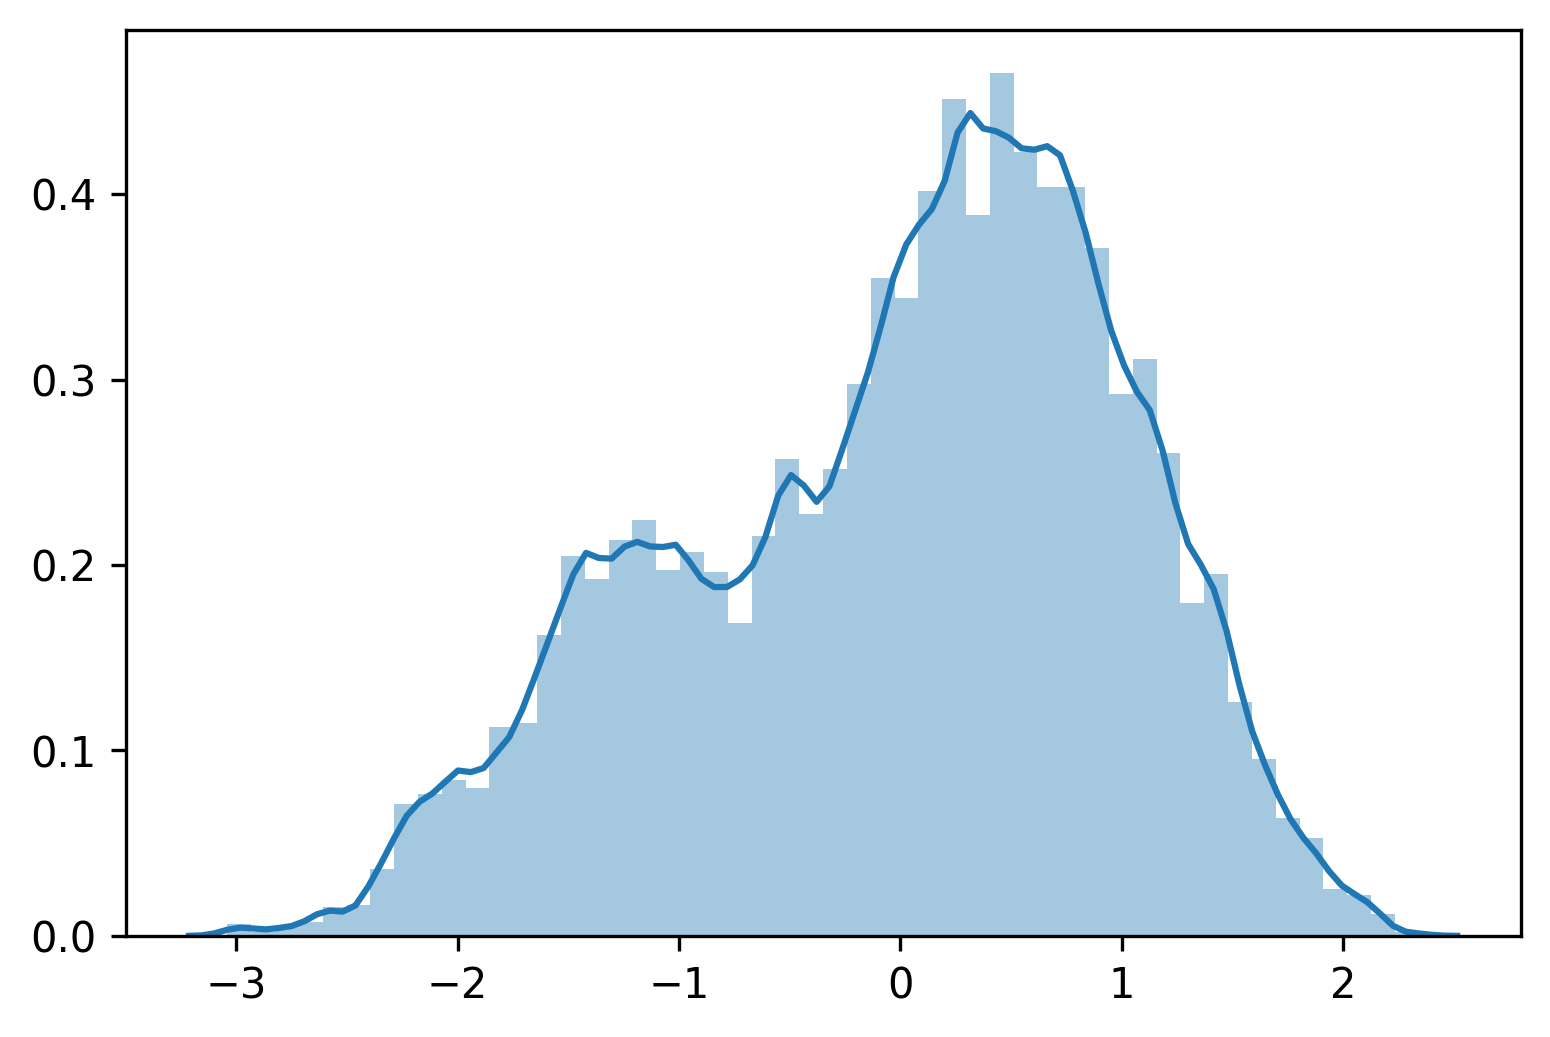

In [30]:
plot_feature(header, x, "Temperature (°C)")

## II.2. Correlation of features and output

### II.2.1. Correlation matrix of the features

In [31]:
def corr_matrix(header, x):
    mask = np.zeros((x.shape[1], x.shape[1]), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.figure(figsize=(14, 12), dpi=300)
    sns.heatmap(np.corrcoef(x.T),
                mask=mask,
                center=0,
                cmap=cmap,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5},
                xticklabels=header,
                yticklabels=header)
    plt.show()

### II.2.2. Correlation between each features with the output

In [32]:
def feature_output_corr(header, x, y):
    coeff = [np.corrcoef(feature, y)[0][1] for feature in x.T]
    abs_coeff = list(map(abs, coeff))
    for _, coeff, name in sorted(zip(abs_coeff, coeff, header), reverse=True):
        print("{:30} : {:6.3f}".format(name, coeff))

In [33]:
feature_output_corr(header, x, y)

Temperature (°C)               :  0.331
Relativite humidity (%)        : -0.294
Hour                           :  0.288
Visibility (km)                :  0.233
Drew point (°C)                :  0.116
Wind speed (km/h)              :  0.107
Pluie                          : -0.095
Year 2016                      :  0.088
Year 2015                      : -0.088
Month 4                        : -0.087
Month 10                       : -0.084
Month 11                       : -0.076
Month 7                        :  0.072
Brouillard                     : -0.066
Sunday                         : -0.056
Month 8                        :  0.055
Dégagé                         : -0.049
wind direction (10s deg)       :  0.042
Month 6                        :  0.039
Station Code                   : -0.038
Thursday                       :  0.035
Bruine                         : -0.031
Généralement dégagé            :  0.028
Généralement nuageux           :  0.028
Saturday                       : -0.025


In [34]:
feature_output_corr(header, x, label)

Temperature (°C)               :  0.198
Relativite humidity (%)        : -0.167
Hour                           :  0.146
Visibility (km)                :  0.139
Drew point (°C)                :  0.073
Year 2016                      :  0.062
Year 2015                      : -0.062
Wind speed (km/h)              :  0.062
Month 4                        : -0.056
Month 10                       : -0.055
Pluie                          : -0.051
Month 7                        :  0.048
Month 11                       : -0.045
Month 8                        :  0.037
Sunday                         : -0.035
Brouillard                     : -0.034
Station Code                   : -0.033
Dégagé                         : -0.032
Month 6                        :  0.025
wind direction (10s deg)       :  0.025
Thursday                       :  0.021
Nuageux                        : -0.020
Saturday                       : -0.019
Wednesday                      :  0.016
Bruine                         : -0.016


# Models

## 1.1 Split into train and validation subsets

In [35]:
split = int(x.shape[0] * 0.8)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]
label_train, label_test = label[:split], label[split:]

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [37]:
def compute_f1(proba, y_true, step=0.01, plot=False):
    f1 = []

    for threshold in np.arange(0, 1, step):
        y_pred = [int(y > threshold) for y in proba]
        f1.append(f1_score(y_true, y_pred) if 1 in y_pred else 0)

    if plot:
        plt.figure(figsize=(6, 4), dpi=300)
        plt.plot(np.arange(0, 1, step), f1)
        plt.xlabel('Threshold')
        plt.ylabel('F1-score')
        plt.show()

    return max(f1), step * np.argmax(f1)

### Logistic regression

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
model = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: 6})
model = model.fit(x_train, label_train)

/home/quentin/venv3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
prediction = model.predict_proba(x_test)
proba = list(zip(*prediction))[1]

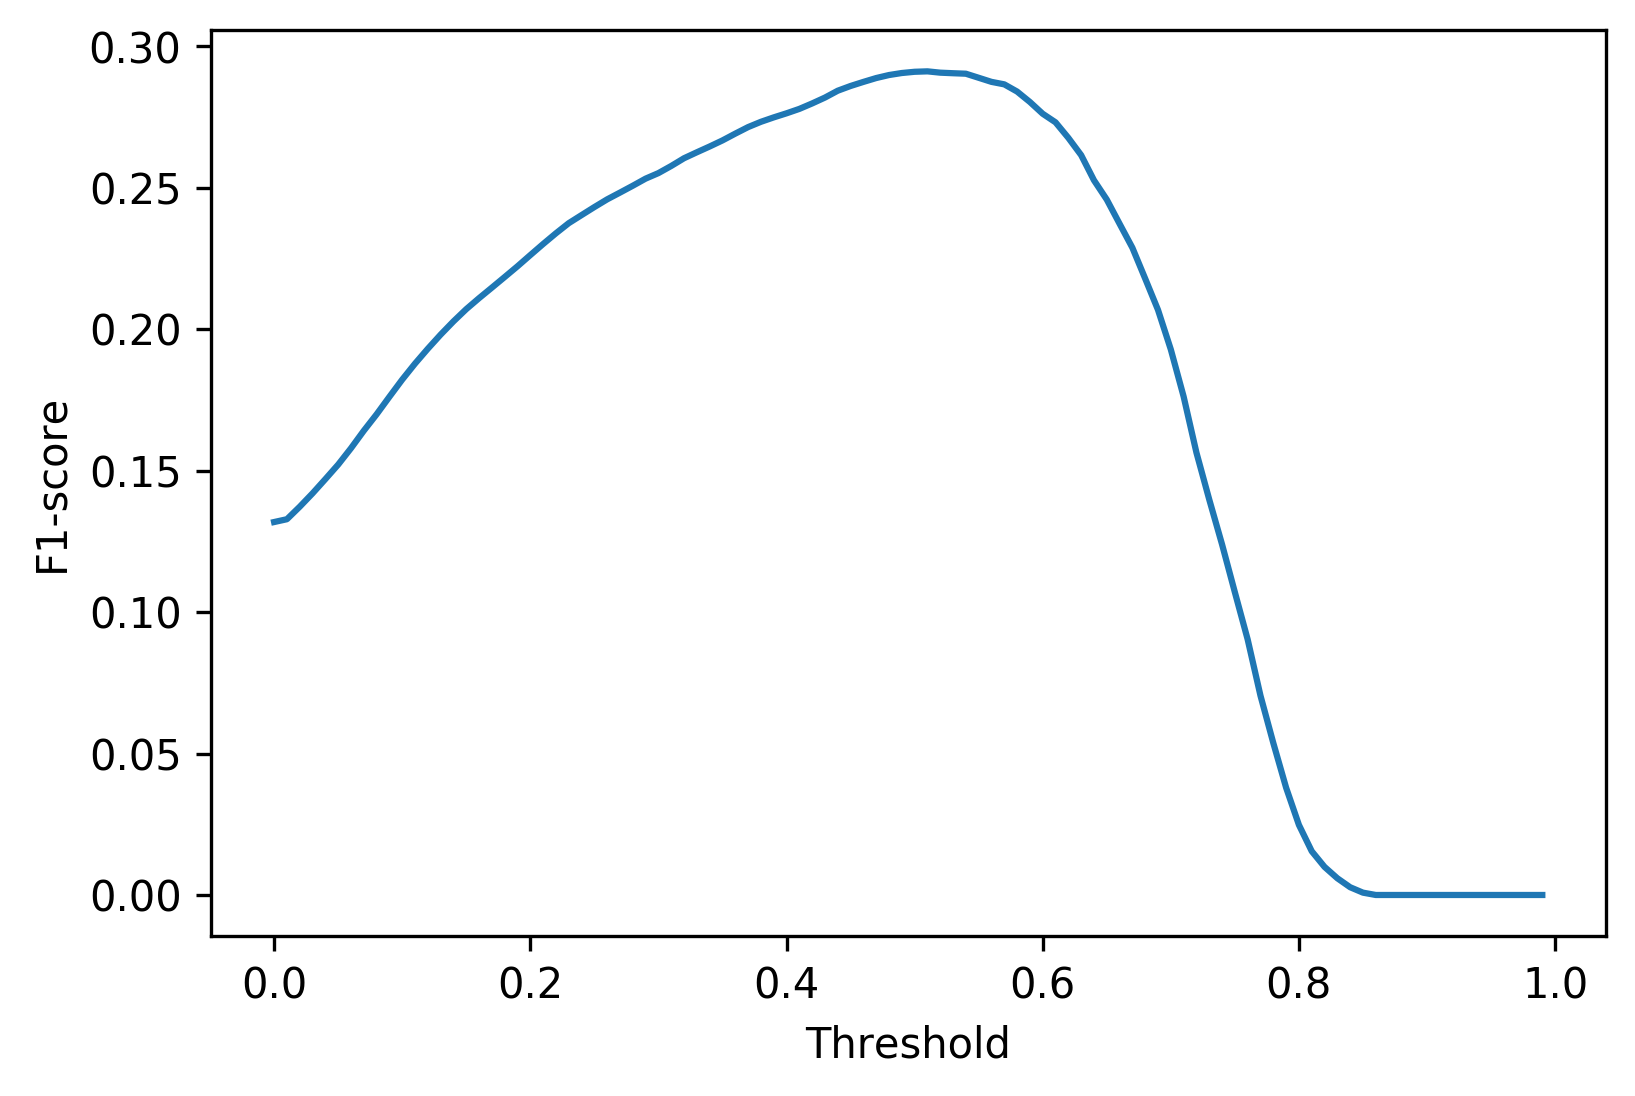

(0.2911576249466041, 0.51)

In [41]:
compute_f1(proba, label_test, plot=True)